In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import euclidean, mahalanobis
from tabulate import tabulate

In [2]:
data = pd.read_csv('kc2.csv', header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [3]:
class KNearestNeighbors:
    def __init__(self, k=5, distance='euclidean'):
        self.k = k
        self.distance = distance
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        if self.distance == 'mahalanobis':
            self.cov = np.linalg.inv(np.cov(X_train, rowvar=False))

    def pred(self, X_test):
        distances = np.zeros((X_test.shape[0], self.X_train.shape[0]))
        if self.distance == 'euclidean':
            for i in range(X_test.shape[0]):
                for j in range(self.X_train.shape[0]):
                    distances[i][j] = euclidean(self.X_train[j], X_test[i])
        else:
            for i in range(X_test.shape[0]):
                for j in range(self.X_train.shape[0]):
                    distances[i][j] = mahalanobis(self.X_train[j], X_test[i], self.cov)
        
        sorted_indexes = np.argsort(distances, axis=1)
        neighbors = self.y_train[sorted_indexes[:, :self.k]].reshape(X_test.shape[0], self.k)
        result = np.zeros((neighbors.shape[0], 1))
        for i in range(neighbors.shape[0]):
            result[i] = np.argmax(np.bincount(neighbors[i].astype(int)))
        return result

In [4]:
folder = KFold(n_splits=10, shuffle=True)
normalizer = StandardScaler()

models = [
    ("Euclidean k=1", KNearestNeighbors(1, 'euclidean')),
    ("Euclidean k=5", KNearestNeighbors(5, 'euclidean')),
    ("Mahalanobis k=1", KNearestNeighbors(1, 'mahalanobis')),
    ("Mahalanobis k=5", KNearestNeighbors(5, 'mahalanobis'))
]

metrics = np.zeros((4, 10, 4))

for i, (train_index, test_index) in enumerate(folder.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)
    
    for j, (name, model) in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.pred(X_test)
        
        metrics[j][i] = np.array([
            accuracy_score(y_test, y_pred),
            recall_score(y_test, y_pred, average='binary', zero_division=0),
            precision_score(y_test, y_pred, average='binary', zero_division=0),
            f1_score(y_test, y_pred, average='binary')
        ])

mean_metrics = np.mean(metrics, axis=1)
std_metrics = np.std(metrics, axis=1, ddof=1)

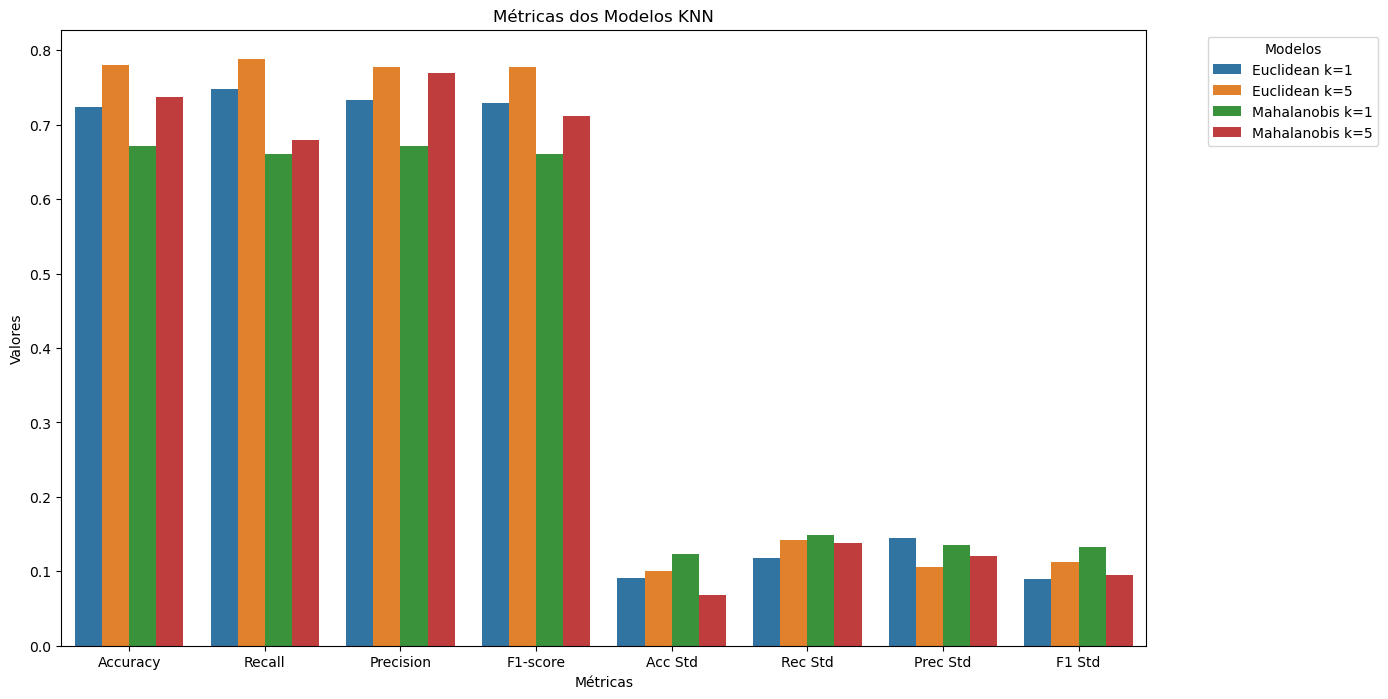

In [5]:
metrics_df = pd.DataFrame(
    np.hstack((mean_metrics, std_metrics)),
    columns=['Accuracy', 'Recall', 'Precision', 'F1-score', 'Acc Std', 'Rec Std', 'Prec Std', 'F1 Std'],
    index=['Euclidean k=1', 'Euclidean k=5', 'Mahalanobis k=1', 'Mahalanobis k=5']
)

metrics_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Gráfico de barras
plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='index')
plt.title('Métricas dos Modelos KNN')
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.legend(title='Modelos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [6]:
table_data = []
for i, (name, model) in enumerate(models):
    table_data.append([
        name,
        f"{mean_metrics[i, 0]:.3f} ± {std_metrics[i, 0]:.3f}",
        f"{mean_metrics[i, 1]:.3f} ± {std_metrics[i, 1]:.3f}",
        f"{mean_metrics[i, 2]:.3f} ± {std_metrics[i, 2]:.3f}",
        f"{mean_metrics[i, 3]:.3f} ± {std_metrics[i, 3]:.3f}"
    ])

print(tabulate(table_data, headers=['Model', 'Accuracy', 'Recall', 'Precision', 'F1-score'], tablefmt='grid'))

+-----------------+---------------+---------------+---------------+---------------+
| Model           | Accuracy      | Recall        | Precision     | F1-score      |
+=================+===============+===============+===============+===============+
| Euclidean k=1   | 0.724 ± 0.091 | 0.748 ± 0.118 | 0.733 ± 0.145 | 0.729 ± 0.090 |
+-----------------+---------------+---------------+---------------+---------------+
| Euclidean k=5   | 0.780 ± 0.100 | 0.788 ± 0.142 | 0.777 ± 0.106 | 0.778 ± 0.112 |
+-----------------+---------------+---------------+---------------+---------------+
| Mahalanobis k=1 | 0.672 ± 0.123 | 0.661 ± 0.149 | 0.671 ± 0.135 | 0.661 ± 0.132 |
+-----------------+---------------+---------------+---------------+---------------+
| Mahalanobis k=5 | 0.738 ± 0.069 | 0.679 ± 0.138 | 0.769 ± 0.121 | 0.712 ± 0.095 |
+-----------------+---------------+---------------+---------------+---------------+


In [7]:
folder = KFold(n_splits=10, shuffle=True)
models = [
    ("Gini Model", DecisionTreeClassifier(criterion='gini')),
    ("Entropy Model", DecisionTreeClassifier(criterion='entropy'))
]

metrics = np.zeros((2, 10, 4))

for i, (train_index, test_index) in enumerate(folder.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)
    
    for j, (name, model) in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        metrics[j][i] = np.array([
            accuracy_score(y_test, y_pred),
            recall_score(y_test, y_pred, average='binary', zero_division=0),
            precision_score(y_test, y_pred, average='binary', zero_division=0),
            f1_score(y_test, y_pred, average='binary')
        ])

mean_metrics = np.mean(metrics, axis=1)
std_metrics = np.std(metrics, axis=1, ddof=1)

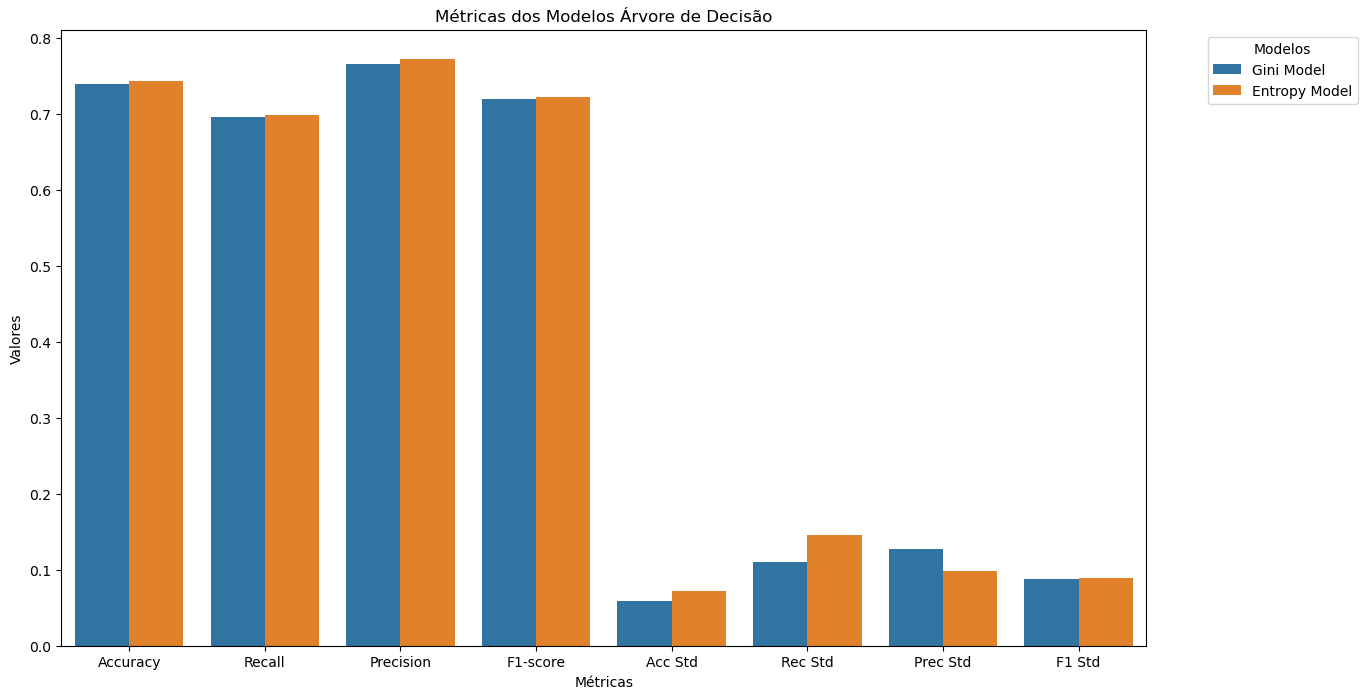

In [8]:
metrics_df = pd.DataFrame(
    np.hstack((mean_metrics, std_metrics)),
    columns=['Accuracy', 'Recall', 'Precision', 'F1-score', 'Acc Std', 'Rec Std', 'Prec Std', 'F1 Std'],
    index=['Gini Model', 'Entropy Model']
)

metrics_melted = metrics_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Gráfico de barras
plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='index')
plt.title('Métricas dos Modelos Árvore de Decisão')
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.legend(title='Modelos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [9]:
table_data = []
for i, (name, model) in enumerate(models):
    table_data.append([
        name,
        f"{mean_metrics[i, 0]:.3f} ± {std_metrics[i, 0]:.3f}",
        f"{mean_metrics[i, 1]:.3f} ± {std_metrics[i, 1]:.3f}",
        f"{mean_metrics[i, 2]:.3f} ± {std_metrics[i, 2]:.3f}",
        f"{mean_metrics[i, 3]:.3f} ± {std_metrics[i, 3]:.3f}"
    ])

print(tabulate(table_data, headers=['Model', 'Accuracy', 'Recall', 'Precision', 'F1-score'], tablefmt='grid'))

+---------------+---------------+---------------+---------------+---------------+
| Model         | Accuracy      | Recall        | Precision     | F1-score      |
+===============+===============+===============+===============+===============+
| Gini Model    | 0.738 ± 0.059 | 0.695 ± 0.110 | 0.766 ± 0.127 | 0.720 ± 0.087 |
+---------------+---------------+---------------+---------------+---------------+
| Entropy Model | 0.742 ± 0.072 | 0.699 ± 0.146 | 0.772 ± 0.099 | 0.722 ± 0.090 |
+---------------+---------------+---------------+---------------+---------------+
